# Style transfer

#### Setup

In [1]:
import os

try:
    from google.colab import drive
    drive.mount('/content/drive')

    # Change the directory
    os.chdir('/content/drive/MyDrive/ColabNotebooks/style-transfer')
    is_colab = True
    print("Running on Colab")

except:
    is_colab = False
    print("Running locally")

Running locally


In [5]:
# 35s
if is_colab:
    ! pip install pretty_midi
    # ! apt-get install musescore
    ! pip install dfply

    # ! pip install pyfluidsynth
    # ! apt install fluidsynth

    # !cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

In [1]:
#3s
import random
random.seed(42)

import glob
import pandas as pd
from utils.files_utils import save_pickle, load_pickle, data_path, preprocessed_data_path, datasets_path
from utils.plots_utils import plot_train
from utils.audio_management import save_audios
from model.train import train_model
from model.colab_tension_vae.params import init
from pipeline_tests.test_training import test_reconstruction
from preprocessing import preprocess_data
from tensorflow import keras

2022-12-05 18:31:54.242129: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-05 18:31:54.242150: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Parámetros

In [12]:
#@title Parámetros ajustables

#@markdown Seleccionar directorios de los datasets
dataset_name = "bach-rag-moz-fres-4" #@param {type:"string"}
model_name = "brmf_4b" #@param {type:"string"}
config_name = "4bar" #@param ["8bar", "4bar"]
init(config_name)

#@markdown ¿Entrenamos un nuevo modelo?
if_train = False #@param {type:"boolean"}
verbose = True #@param {type:"boolean"}

#@markdown ¿Cuántas épocas? ¿Cada cuánto grabamos?
epochs =  10#@param {type:"integer"}
checkpt =  1#@param {type:"integer"}

#@markdown Datasets:
dataset1 = "Bach/" #@param {type:"string"}
dataset2 = "ragtime/" #@param {type:"string"}
dataset3 = "Mozart/" #@param {type:"string"}
dataset4 = "Frescobaldi/" #@param {type:"string"}

ds1_path = os.path.join(datasets_path, dataset1)
ds2_path = os.path.join(datasets_path, dataset2)
ds3_path = os.path.join(datasets_path, dataset3)
ds4_path = os.path.join(datasets_path, dataset4)

songs = {
    dataset1[:-1]: [os.path.join(ds1_path, path) for path in os.listdir(ds1_path)],
    dataset2[:-1]: [os.path.join(ds2_path, path) for path in os.listdir(ds2_path)],
    dataset3[:-1]: [os.path.join(ds3_path, path) for path in os.listdir(ds3_path)],
    dataset4[:-1]: [os.path.join(ds4_path, path) for path in os.listdir(ds4_path)],
}

In [ ]:
#@title Transformar estilo
ds_original = "Bach" #@param ["Bach", "ragtime", "Mozart", "Frescobaldi"]
ds_objetivo = "Mozart" #@param ["Bach", "ragtime", "Mozart", "Frescobaldi"]

nombre_pickle = ds_original+"2"+ds_objetivo

____
# Preprocessing and Model

Se lo lleva al formato lista de:

- $n$ canciones = lista de:
- 2 voces = lista de:
- $e$ eventos (notas, silencios, etc.)


Armamos el DataFrame con el que manejamos las canciones. Cada fila es una canción y las columnas son:
- `Style`
- `Título`
- `Id roll`: qué matriz es de la canción
- `Roll` objeto (GuoRoll) con:
    - `matrix`: matriz de $16*n \times 89$ con $n=$ la cantidad de compases
    - `bars`: cantidad de compases por matriz (es el mismo para todo el dataset, con lo cual, podría eliminarse la redundancia en un trabajo futuro)
    - `song`: referencia al objeto `song` al que pertenece si fue obtenido de ahí. Si fue obtenido desde un embedding, es `None` (en un trabajo futuro podría cambiárselo por un singleton).
    - `score`: partitura obtenida a partir de la matriz
    - `midi`: Pretty MIDI obtenido a partir de la matriz

Luego le agregaremos:
- `Embedding`: el vector resultado de encodear el roll

## Preprocessing

In [13]:
try:
    df_preprocessed = load_pickle(file_name=preprocessed_data_path+dataset_name, verbose=verbose)
except:
    print("Processing dataset")
    df_preprocessed = preprocess_data(songs)
    save_pickle(df_preprocessed, file_name=preprocessed_data_path+dataset_name, verbose=verbose)

Loaded file: <_io.BufferedReader name='/home/urania/Documentos/Tesis/src/style-transfer/data/preprocessed_data_path/bach-rag-moz-fres-4.pkl'>


## Model

In [ ]:
if if_train:
    vae = train_model(
        df=df_preprocessed,
        model_name=model_name,
        final_epoch=epochs,
        ckpt=checkpt,
        verbose=verbose
    )
else:
    vae = keras.models.load_model(data_path + f"saved_models/{model_name}/")

In [ ]:
glob.glob(rf"{data_path}logs/{model_name}_*.csv")

In [ ]:
id_file =  790#@param {type:"integer"}

callbacks = pd.read_csv(data_path + f"logs/{model_name}_{id_file}.csv")
plot_train(callbacks, epochs)

## Test reconstruction

In [ ]:
if is_colab:
  ! sudo apt install lilypond

test_reconstruction(df_preprocessed, vae, model_name, samples=5, inplace=False, verbose=verbose)

# Working space

In [10]:
df = pd.read_csv(f"{data_path}/debug_outputs/table_intervals-all_single.csv", index_col=0)
df

,Transference,Improvement ratio
0,ragtime to Bach got away,0.366120
1,ragtime to Bach got closer,0.185792
2,Bach to ragtime got away,0.754098
3,Bach to ragtime got closer,0.814208
4,Frescobaldi to Bach got away,0.270718
5,Frescobaldi to Bach got closer,0.071823
6,Bach to Frescobaldi got away,0.397790
7,Bach to Frescobaldi got closer,0.928177
8,Mozart to Bach got away,0.314286
9,Mozart to Bach got closer,0.057143


In [15]:
df.sort_values(by="Improvement ratio", ascending=False)

,Transference,Improvement ratio
11,Bach to Mozart got closer,0.942857
22,Mozart to ragtime got away,0.939394
7,Bach to Frescobaldi got closer,0.928177
20,ragtime to Mozart got away,0.878788
14,Frescobaldi to ragtime got away,0.861111
3,Bach to ragtime got closer,0.814208
21,ragtime to Mozart got closer,0.772727
2,Bach to ragtime got away,0.754098
16,Frescobaldi to Mozart got away,0.718750
17,Frescobaldi to Mozart got closer,0.718750


In [7]:
d = {os.path.basename(style_path): len(os.listdir(f"{datasets_path}/{style_path}")) for style_path in os.listdir(datasets_path)}
d

{'debug': 2,
 'ragtime': 37,
 'Bach': 166,
 'debug-2': 1,
 'Frescobaldi': 39,
 'Mozart': 52}

In [8]:
df_preprocessed = load_pickle(os.path.join(preprocessed_data_path, "bach-rag-moz-fres-4.pkl"))
df_preprocessed

,Autor,Titulo,roll
0,Bach,bwv0401,<roll.guoroll.GuoRoll object at 0x7f6814f0f1c0>
1,Bach,bwv0401,<roll.guoroll.GuoRoll object at 0x7f6799b7f220>
2,Bach,bwv0401,<roll.guoroll.GuoRoll object at 0x7f6799b7fe20>
3,Bach,bwv0381,<roll.guoroll.GuoRoll object at 0x7f6799bb98b0>
4,Bach,bwv0381,<roll.guoroll.GuoRoll object at 0x7f6799b5d4c0>
...,...,...,...
3845,ragtime,stoptime,<roll.guoroll.GuoRoll object at 0x7f6760d2df10>
3846,ragtime,stoptime,<roll.guoroll.GuoRoll object at 0x7f6760cf5190>
3847,ragtime,stoptime,<roll.guoroll.GuoRoll object at 0x7f6760c98640>
3848,ragtime,stoptime,<roll.guoroll.GuoRoll object at 0x7f6760c3cc70>


In [14]:
d = {"Frescobaldi": (df_preprocessed[df_preprocessed["Autor"] == "Frescobaldi"]).shape[0],
     "Bach": (df_preprocessed[df_preprocessed["Autor"] == "Bach"]).shape[0],
     "Mozart":(df_preprocessed[df_preprocessed["Autor"] == "Mozart"]).shape[0],
     "ragtime":(df_preprocessed[df_preprocessed["Autor"] == "ragtime"]).shape[0]
     }
d

{'Frescobaldi': 661, 'Bach': 508, 'Mozart': 1309, 'ragtime': 1372}

In [13]:
def save_midis(df, verbose=False):
    rolls_generated = df[df.columns[-1]]
    midis = [r.midi for r in rolls_generated]
    save_audios(df['Title'], midis, verbose=verbose)


In [14]:
df_preprocessed.head()

,Autor,Titulo,roll
0,Bach,bwv0401,<roll.guoroll.GuoRoll object at 0x7f1b20e39340>
1,Bach,bwv0401,<roll.guoroll.GuoRoll object at 0x7f1b208fab50>
2,Bach,bwv0401,<roll.guoroll.GuoRoll object at 0x7f1b20b54970>
3,Bach,bwv0381,<roll.guoroll.GuoRoll object at 0x7f1b20b50b20>
4,Bach,bwv0381,<roll.guoroll.GuoRoll object at 0x7f1b20a344f0>


In [4]:
from utils.files_utils import get_transferred_path

df_reconstructed = load_pickle(get_transferred_path('Bach', 'ragtime', "brmf_4b"))
df_reconstructed.head()

,Autor,Titulo,roll,Embedding,Embedding-NewRoll
1866,ragtime,antoinette.mid,<roll.guoroll.GuoRollSmall object at 0x7f0cd97...,"[-0.0043747313, 1.41698, -1.5279223, -0.020506...",<roll.guoroll.GuoRoll object at 0x7f0cd8b51190>
758,ragtime,breeze.mid,<roll.guoroll.GuoRollSmall object at 0x7f0cd93...,"[-0.051136367, 0.73456746, -0.91220284, -2.043...",<roll.guoroll.GuoRoll object at 0x7f0cd8b80220>
70,Bach,bwv0253.mid,<roll.guoroll.GuoRollSmall object at 0x7f0cd93...,"[-0.6771048, -0.15007068, -0.12760165, 0.50512...",<roll.guoroll.GuoRoll object at 0x7f0cd8b39190>
29,Bach,bwv0254.mid,<roll.guoroll.GuoRollSmall object at 0x7f0cd93...,"[-2.185468, 1.9231098, 1.0495294, 5.617977, 2....",<roll.guoroll.GuoRoll object at 0x7f0cd8add670>
91,Bach,bwv0255.mid,<roll.guoroll.GuoRollSmall object at 0x7f0cd93...,"[-0.8813409, -0.5599785, -1.5920982, 3.2512496...",<roll.guoroll.GuoRoll object at 0x7f0cd8aff6a0>


In [4]:
df_transferred = load_pickle(get_transferred_path('Bach', 'ragtime', "brmf_4b"))
df_transferred.head()

,Autor,Titulo,roll,Embedding,Mutacion_add,Mutacion_add_sub,Mutacion_add_sub-Bach2Frescobaldi
70,Bach,bwv0253.mid,<roll.guoroll.GuoRoll object at 0x7f14725dca60>,"[-0.6771048, -0.15007068, -0.12760165, 0.50512...","[-0.9170938, -0.69383276, -1.194445, 1.6231658...","[-0.70293194, -0.3269844, -0.22040199, -1.6397...",<roll.guoroll.GuoRoll object at 0x7f146b9d1910>
29,Bach,bwv0254.mid,<roll.guoroll.GuoRoll object at 0x7f1471ab8070>,"[-2.185468, 1.9231098, 1.0495294, 5.617977, 2....","[-2.425457, 1.3793477, -0.017313957, 6.736017,...","[-2.2112951, 1.746196, 0.9567291, 3.4731061, 1...",<roll.guoroll.GuoRoll object at 0x7f146b9e9610>
91,Bach,bwv0255.mid,<roll.guoroll.GuoRoll object at 0x7f1471a8de80>,"[-0.8813409, -0.5599785, -1.5920982, 3.2512496...","[-1.12133, -1.1037406, -2.6589417, 4.36929, 1....","[-0.9071681, -0.7368922, -1.6848986, 1.1063786...",<roll.guoroll.GuoRoll object at 0x7f146b978c40>
98,Bach,bwv0256.mid,<roll.guoroll.GuoRoll object at 0x7f1471a6ba00>,"[0.45691258, -0.8111836, -1.684641, 0.9001678,...","[0.21692352, -1.3549457, -2.7514844, 2.018208,...","[0.43108544, -0.9880973, -1.7774414, -1.244703...",<roll.guoroll.GuoRoll object at 0x7f146b996070>
47,Bach,bwv0258.mid,<roll.guoroll.GuoRoll object at 0x7f1471988ee0>,"[-0.6578047, 2.4769223, 1.2892462, -1.7592773,...","[-0.89779377, 1.9331602, 0.22240281, -0.641237...","[-0.6836319, 2.3000085, 1.1964458, -3.9041483,...",<roll.guoroll.GuoRoll object at 0x7f146b936ac0>


In [ ]:
h = df_transferred.head(1)
for f in h.iterrows():
    for c in f:
        print(c)
    print("-------------\nSolo el estilo:", c["Style"])

In [ ]:
for f in os.listdir(f"{data_path}embeddings/brmf_4b"):
    if "df_transferred" in f:
        df = load_pickle(f"{data_path}embeddings/brmf_4b/{f}")
        save_midis(df, verbose=True)

___

In [9]:
# %cd ..
from model.embeddings.characteristics import obtain_characteristics
from sklearn.manifold import TSNE
import numpy as np
from keras.saving.save import load_model
from utils.files_utils import get_characteristics_path, get_emb_path
from dodo import preprocessed_data_path
import os

model_name = 'brmf_4b'
model_path = data_path + '/brmf_4b/vae'

def df_characteristics(df, characteristics, plot_path, plot_name="characteristics"):
    df_tsne = df[["Style", "Embedding"]]
    df_tsne["Type"] = df.shape[0] * ["Fragment"]

    for style, emb in characteristics.items():
        df_tsne.loc[len(df_tsne.index)] = [style, emb, "Style"]

    tsne: np.ndarray = TSNE(n_components=2).fit_transform(list(df_tsne['Embedding']))

    return df_tsne, tsne

    # grid = plot_tsne(df, tsne, plot_path, plot_name, style="Type", markers={"Embedding": '.', "Fragment": 'x'})
    # return grid


def do_embeddings(df_path, model_path, characteristics_path, emb_path, bars):
    init(bars)
    model = load_model(model_path)
    plots_path = os.path.join(data_path, model_path, "plots")
    df = load_pickle(df_path)

    df_emb, styles_char = obtain_characteristics(df, model)
    # tsne_emb = calculate_TSNEs(df_emb, column_discriminator="Style")[0]

    return df_characteristics(df_emb, styles_char, plots_path)


df, tsne = do_embeddings(preprocessed_data_path(4), model_path, get_characteristics_path(model_name), get_emb_path(model_name), 4)

/tmp/ipykernel_28521/1070315380.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tsne["Type"] = df.shape[0] * ["Fragment"]
/tmp/ipykernel_28521/1070315380.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tsne.loc[len(df_tsne.index)] = [style, emb, "Style"]
/tmp/ipykernel_28521/1070315380.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tsne.loc[len(df_tsne.in

In [11]:
tsne: np.ndarray = TSNE(n_components=2).fit_transform(list(df['Embedding']))

tsne.shape

(249, 2)

In [13]:
# 

df['dim_1'] = tsne[:, 0]
df['dim_2'] = tsne[:, 1]
# tsne.shape
df

,Style,Embedding,Type,dim_1,dim_2
2747,ragtime,"[1.7091504, 0.16362531, 0.5528342, 0.66308755,...",Fragment,-15.035623,0.491483
119,Bach,"[0.67035353, 0.64418495, 2.1261027, 1.4352599,...",Fragment,17.619982,3.645020
274,Bach,"[1.8708336, -0.077583656, -0.3342189, -0.85113...",Fragment,0.110676,-3.626946
455,Bach,"[-1.5037862, 0.61034524, 0.3631019, 0.08908154...",Fragment,3.853758,7.847368
383,Bach,"[-1.3077334, -0.0347018, -0.53865767, 0.714756...",Fragment,5.211201,9.301330
...,...,...,...,...,...
3215,ragtime,"[0.6634819, 1.4469888, -2.0262504, -1.6675949,...",Fragment,-10.962152,-4.521760
2556,ragtime,"[0.3593005, 0.69681, -2.8436573, 1.0776114, 1....",Fragment,-9.637630,4.409436
3703,ragtime,"[0.5540268, 0.9899851, -1.4044183, -0.10276914...",Fragment,-9.057597,3.534801
247,Frescobaldi,"[-0.19190997, 0.39909664, -0.25570345, -0.9977...",Style,0.845282,7.526373


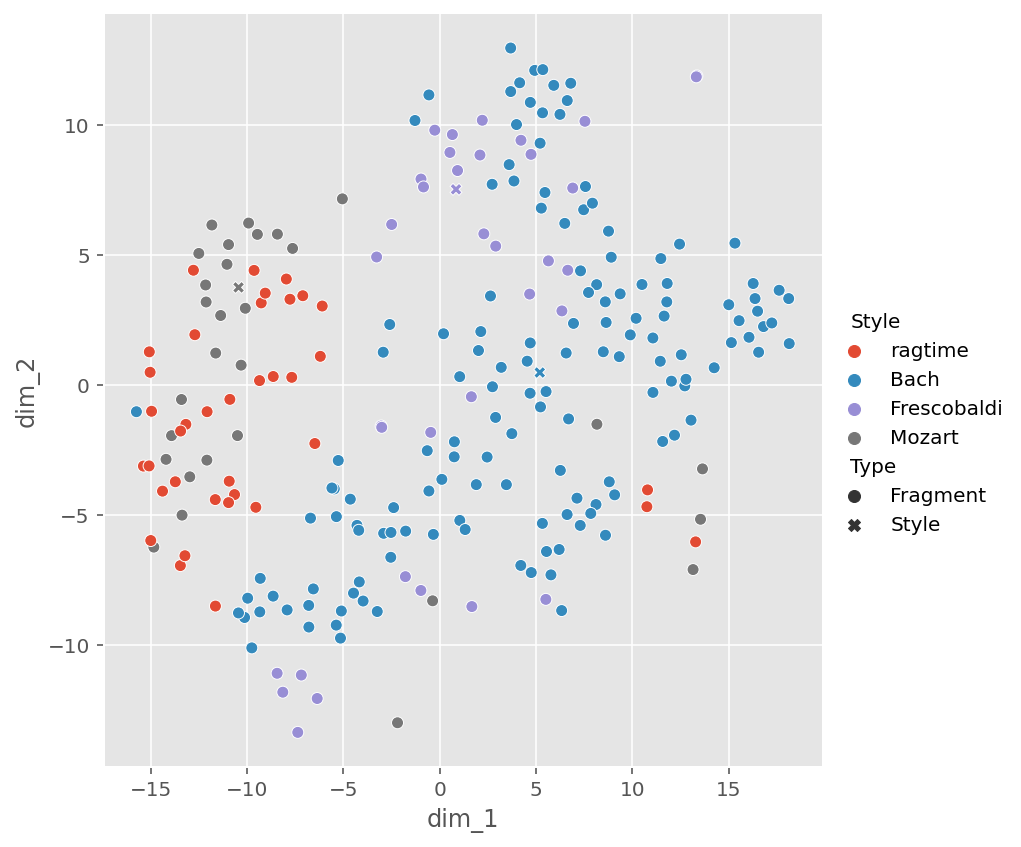

In [18]:
import seaborn as sns

sns.relplot(x='dim_1', 
            y='dim_2', 
            hue='Style', 
            data=df, 
            kind='scatter', 
            height=6, 
            style="Type", 
           )